# P7: Implémentez un modèle de scoring

**Introduction**

Vous êtes Data Scientist au sein d'une société financière, nommée **"Prêt à dépenser"**,  qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

De plus, les chargés de relation client ont fait remonter le fait que les clients sont de plus en plus demandeurs de transparence vis-à-vis des décisions d’octroi de crédit. Cette demande de transparence des clients va tout à fait dans le sens des valeurs que l’entreprise veut incarner.

Prêt à dépenser décide donc de développer un dashboard interactif pour que les chargés de relation client puissent à la fois expliquer de façon la plus transparente possible les décisions d’octroi de crédit, mais également permettre à leurs clients de disposer de leurs informations personnelles et de les explorer facilement.

**Votre mission**
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.

**Spécifications du dashboard**

Celui-ci devra contenir au minimum les fonctionnalités suivantes :

- Permettre de visualiser le score et l’interprétation de ce score pour chaque client de façon intelligible pour une personne non experte en data science.
- Permettre de visualiser des informations descriptives relatives à un client (via un système de filtre).
- Permettre de comparer les informations descriptives relatives à un client à l’ensemble des clients ou à un groupe de clients similaires.

In [1]:
import numpy as np
import pandas as pd 
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import re

## Description des variables

In [2]:

description = pd.read_csv('HomeCredit_columns_description.csv',encoding="ISO-8859-1",index_col=0)
print('HomeCredit_columns_description  shape: ', description.shape)

description.head()

HomeCredit_columns_description  shape:  (219, 4)


,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## Table principal avec la cible: appication_train

Le fichier 'application_train' donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention remboursé ou défaut de payement sur cet emprunt.
Le fichier application_test renseigne exactement les mêmes informations que le fichier 'application_train', mais il s'agit de déterminer la probabilité de défaut de paiement pour ces nouveaux emprunts.

In [3]:
# Training and test data
app_train = pd.read_csv('application_train.csv',index_col=0)
app_test= pd.read_csv('application_test.csv',index_col=0)
print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)
app_train.head()

Training data shape:  (307511, 121)
Test data shape:  (48744, 120)


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
app_test.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


La table de données **train** contient 307511 lignes( chacune étant un prêt distinct) et 121 variables y compris la variable **Target**(celle que l'on cherche à prédire).
La table de données **test** est identique  a la table **train** mais contient moins de lignes (48744) et ne contient pas la variable **Target**.

### Types de Colonnes

Examinons le nombre de colonnes de chaque type de données. int64 et float64 sont des variables numériques (qui peuvent être discrètes ou continues). Les colonnes d’objet contiennent des chaînes et sont des entités catégorielles.

In [62]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      40
object     16
dtype: int64

In [63]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles ont un nombre relativement faible de modalités. Nous devrons trouver un moyen de traiter ces variables catégoriques!

### Variable cible : **TARGET**

La cible est ce qu’on nous demande de prédire: C'est une variable binaire indiquant les deux modalités suivantes:
- soit un 0 indiquant que le prêt a été remboursé à temps, 
- soit un 1 indiquant que le client a eu des difficultés de paiement. 
Nous pouvons d’abord examiner le nombre de prêts entrant dans chaque catégorie.

In [5]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [6]:
# Class ratio
print('TARGET ratio {:.2%}'.format(app_train.TARGET.value_counts()[1]/app_train.TARGET.value_counts()[0]) )

TARGET ratio 8.78%


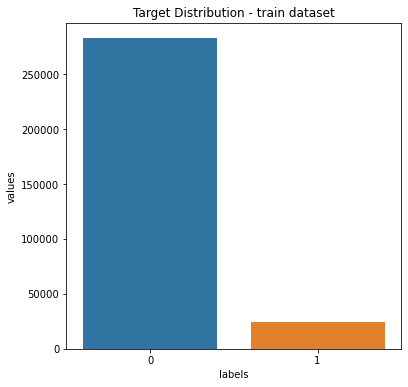

In [7]:
temp = app_train["TARGET"].value_counts()
res = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Target Distribution - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=res)
locs, labels = plt.xticks()
plt.show()

À partir de ces informations, nous voyons qu’il s’agit d’un problème de classe déséquilibré. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n’ont pas été remboursés.
Une fois que nous entrons dans des modèles d’apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes en fonction de leur représentation dans les données pour refléter ce déséquilibre.

Le déséquilibre de classe peut entraîner des problèmes avec l’apprentissage automatique des modèles, car les modèles peuvent être biaisés en faveur de la classe la plus courante.

S’il y a plus d’exemples d’une classe qu’une autre, le modèle sera plus susceptible d’apprendre et de prédire la classe majoritaire. Cela peut être un problème car cela peut conduire à des résultats inexacts lorsque le modèle est appliqué à des données plus équilibrées.

Un problème de classification déséquilibrée se produit lorsque les classes du jeu de données ont un nombre très inégal d’échantillons. Le déséquilibre de classe est un problème courant dans l’apprentissage automatique et peut être difficile à surmonter. Cependant, il est important d’en être conscient afin que des mesures puissent être prises pour en atténuer les effets.

### Distributions de quelques variables catégorielles

In [54]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();
    
def plot_distribution(var):
    
    i = 0
    t1 = app_train.loc[app_train['TARGET'] != 0]
    t0 = app_train.loc[app_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

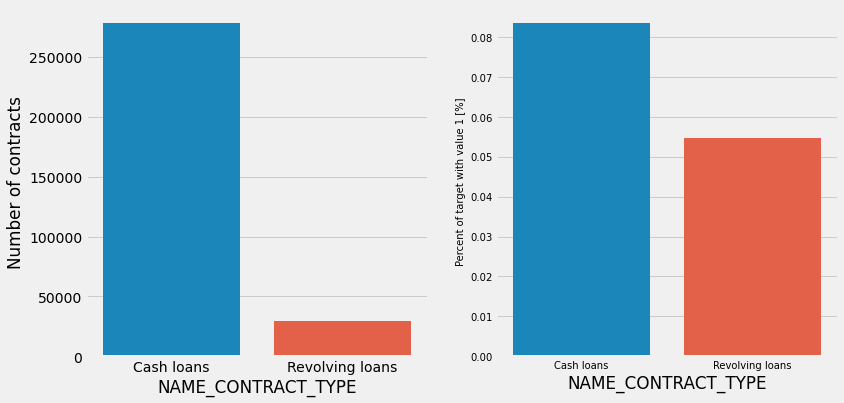

In [55]:
plot_stats('NAME_CONTRACT_TYPE')

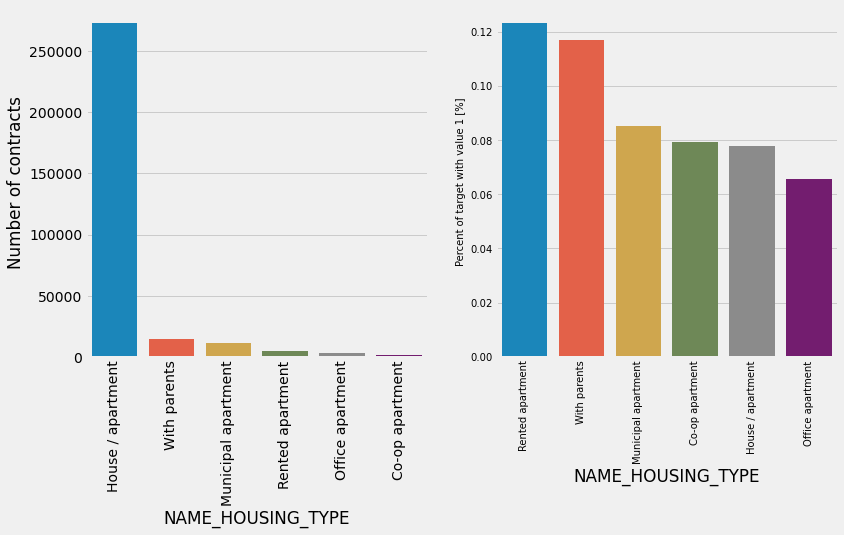

In [57]:
plot_stats('NAME_HOUSING_TYPE',True)

### Distribution de quelques variables numériques

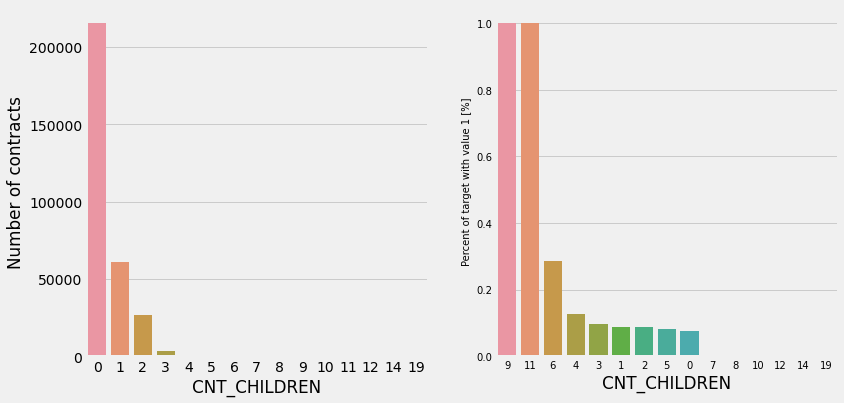

In [58]:
plot_stats('CNT_CHILDREN')

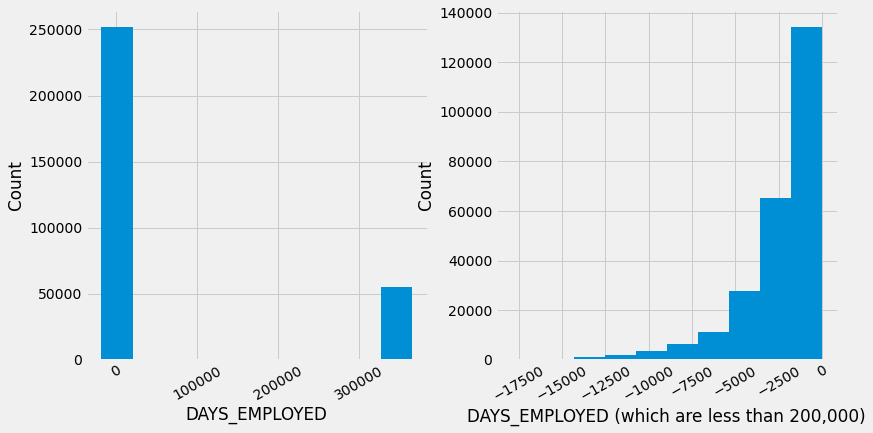

In [50]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app_train['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app_train.loc[app_train['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [51]:
# Affiche les valeurs abérrantes
values_to_nan = app_train.loc[app_train['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


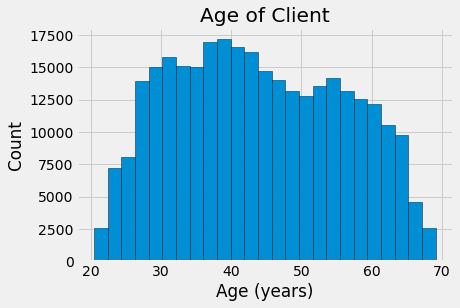

In [13]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [14]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

Il existe une relation linéaire négative entre l'age des clients et la cible, ce qui signifie qu’à mesure que les clients vieillissent, ils ont tendance à rembourser leurs prêts à temps plus souvent.

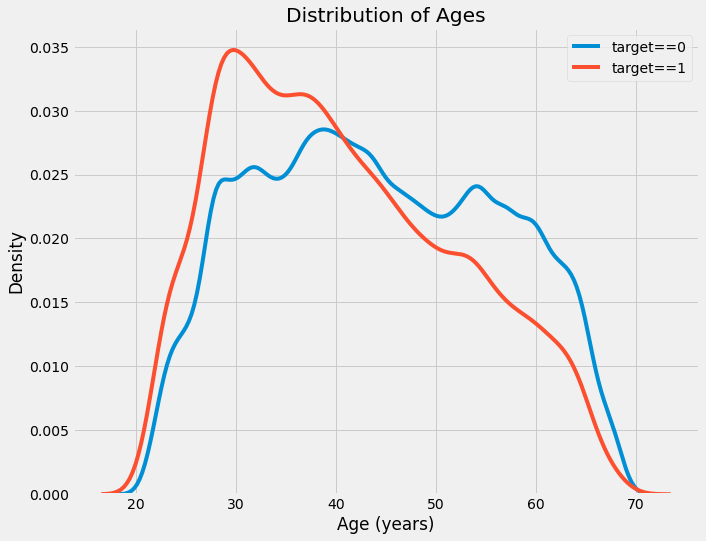

In [32]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target==0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target==1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages'); plt.legend()

### Variables liées aux sources extérieures

In [34]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique qu’à mesure que la valeur du EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt.

Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1 ce qui indique que l’un des facteurs de ce score est peut-être l’âge du client.

Ensuite, nous pouvons visualiser la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de voir l’effet de cette variable sur la cible.

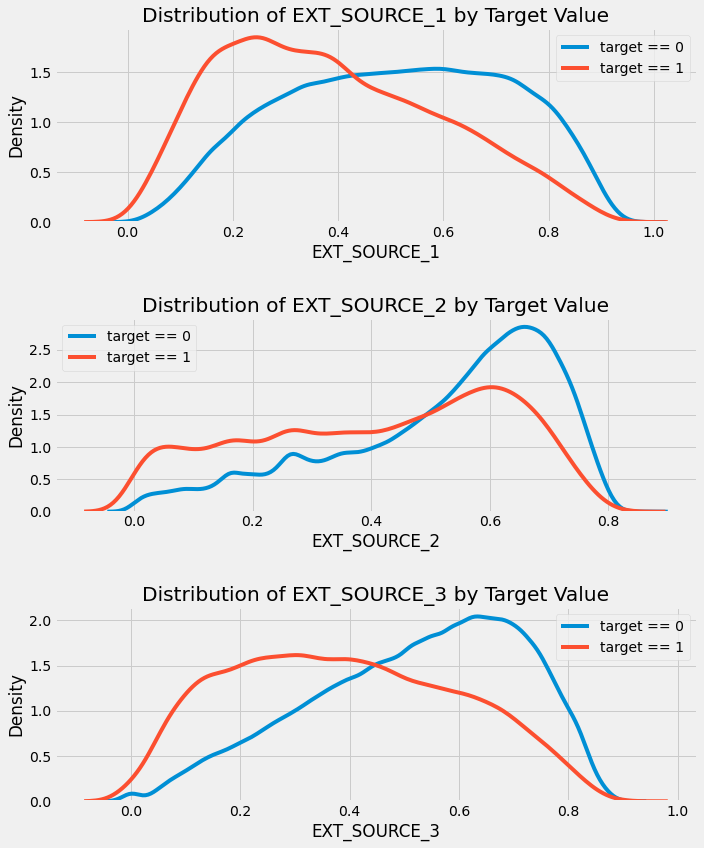

In [35]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');plt.legend()
    
plt.tight_layout(h_pad = 2.5)

**EXT_SOURCE_3** affiche la plus grande différence entre les valeurs de la cible. Nous pouvons clairement voir que cette caractéristique a un certain rapport avec la probabilité qu’un demandeur rembourse un prêt. La relation n’est pas très forte (en fait, ils sont tous considérés comme très faibles, mais ces variables pourrons être utiles pour un modèle d’apprentissage automatique afin de prédire si un demandeur remboursera ou non un prêt à temps.

## Autres fichiers

In [64]:
bureau = pd.read_csv("bureau.csv",index_col=0)
bureau_balance = pd.read_csv("bureau_balance.csv",index_col=0)
previous_application = pd.read_csv("previous_application.csv",index_col=0)
credit_card_balance = pd.read_csv("credit_card_balance.csv",index_col=0)
installments_payments = pd.read_csv("installments_payments.csv",index_col=0)
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv",index_col=0)

In [66]:
print("Dimensions")

dict_df = {
           'bureau shape :' : bureau.shape,
           'bureau_balance shape :' : bureau_balance.shape,
           'POS_CASH_balance shape :' : POS_CASH_balance.shape, 
           'credit_card_balance shape :' : credit_card_balance.shape, 
           'installments_payments shape :' : installments_payments.shape, 
           'previous_application shape:' : previous_application.shape}

for key, value in dict_df.items():
    print(f'{key :-<30} {value}')

Dimensions
bureau shape :---------------- (1716428, 16)
bureau_balance shape :-------- (27299925, 2)
POS_CASH_balance shape :------ (10001358, 7)
credit_card_balance shape :--- (3840312, 22)
installments_payments shape :- (13605401, 7)
previous_application shape:--- (1670214, 36)


In [67]:
bdd=[bureau,bureau_balance,POS_CASH_balance,credit_card_balance,installments_payments,previous_application]
label_bdd=['bureau','bureau_balance','POS_CASH_balance','credit_card_balance','installments_payments','previous_application']

In [68]:
for table,name in zip(bdd,label_bdd):
    print('Variables table :',name)
    print('')
    table.info()
    print('')
    print('-'*100)

Variables table : bureau

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 215354 to 246829
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_BUREAU            int64  
 1   CREDIT_ACTIVE           object 
 2   CREDIT_CURRENCY         object 
 3   DAYS_CREDIT             int64  
 4   CREDIT_DAY_OVERDUE      int64  
 5   DAYS_CREDIT_ENDDATE     float64
 6   DAYS_ENDDATE_FACT       float64
 7   AMT_CREDIT_MAX_OVERDUE  float64
 8   CNT_CREDIT_PROLONG      int64  
 9   AMT_CREDIT_SUM          float64
 10  AMT_CREDIT_SUM_DEBT     float64
 11  AMT_CREDIT_SUM_LIMIT    float64
 12  AMT_CREDIT_SUM_OVERDUE  float64
 13  CREDIT_TYPE             object 
 14  DAYS_CREDIT_UPDATE      int64  
 15  AMT_ANNUITY             float64
dtypes: float64(8), int64(5), object(3)
memory usage: 222.6+ MB

----------------------------------------------------------------------------------------------------
Variables table : bureau_

## Prétraitement des données

In [191]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [170]:
##Preprocess application_train.csv and application_test.csv

def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # remove a outlier 117M
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    #Age of client
    df['AGE']=df['DAYS_BIRTH'] / -365
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [171]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
     # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [172]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [173]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [178]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = None)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


In [181]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [175]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [176]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
        
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [77]:
def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

nan_as_category = True

In [105]:
df = application_train_test()
df = df.merge(bureau_and_balance(), how='left', on='SK_ID_CURR')
print('--=> df after merge with bureau:', df.shape)
df = df.merge(previous_applications(), how='left', on='SK_ID_CURR')
print('--=> df after merge with previous application:', df.shape)
df = df.merge(pos_cash(), how='left', on='SK_ID_CURR')
print('--=> df after merge with pos cash :', df.shape)
df = df.merge(installments_payments(), how='left', on='SK_ID_CURR')
print('--=> df after merge with installments:', df.shape)
df = df.merge(credit_card_balance(), how='left', on='SK_ID_CURR')
print('--=> df after merge with credit card:', df.shape)
df = reduce_mem_usage(df)
print('data types are converted for a reduced memory usage')
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
print('names of feature are renamed')

Train samples: 307511, test samples: 48744
--=> df after merge with bureau: (356250, 365)
--=> df after merge with previous application: (356250, 614)
--=> df after merge with pos cash : (356250, 632)
--=> df after merge with installments: (356250, 658)
--=> df after merge with credit card: (356250, 799)
data types are converted for a reduced memory usage
names of feature are renamed


### Selection de variable selon le taux de remplissage

In [86]:
#Recherche de colonnes contenant 85% de données manquantes
df_zero = pd.DataFrame()
columns = []
percentage =[]
for col in df.columns:
    if col == 'TARGET':
        continue
    count = (df[col] == 0).sum()
    columns.append(col)
    percentage.append(count/len(df[col]))
df_zero['Column'] = columns
df_zero['Percentage'] = percentage
per = 85/100
df_zero = df_zero[df_zero['Percentage']>per]

In [109]:
more_than_85 = df_zero
more_than_85

,Column,Percentage
21,FLAG_EMAIL,0.928786
26,REG_REGION_NOT_LIVE_REGION,0.984351
27,REG_REGION_NOT_WORK_REGION,0.948629
28,LIVE_REGION_NOT_WORK_REGION,0.959152
29,REG_CITY_NOT_LIVE_CITY,0.921923
...,...,...
623,POS_NAME_CONTRACT_STATUS_Canceled_MEAN,0.946616
625,POS_NAME_CONTRACT_STATUS_Demand_MEAN,0.945648
626,POS_NAME_CONTRACT_STATUS_Returned_to_the_store...,0.932474
628,POS_NAME_CONTRACT_STATUS_XNA_MEAN,0.946653


In [112]:
df.shape

(356250, 799)

In [113]:
data_garder=df.copy()

In [114]:
#columns = more_than_85['Column']
data_garder.drop(columns = more_than_85['Column'],inplace = True)
data_garder.shape

(356250, 542)

### Suppression des variables fortement correlées

In [122]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = data_garder.corr().abs()
corr_matrix.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,1.000000,0.837310,0.002096,0.003514,0.002089,0.001561,0.003620,0.013789,0.033421,0.025804,...,0.004458,0.000785,0.006472,0.001554,NaN,NaN,NaN,NaN,NaN,0.000421
SK_ID_CURR,0.837310,1.000000,0.002094,0.000755,0.001548,0.000333,0.000867,0.001496,0.000417,0.000623,...,0.005560,0.006408,0.001296,0.006443,NaN,NaN,NaN,NaN,NaN,0.000617
TARGET,0.002096,0.002094,1.000000,0.054719,0.021842,0.006153,0.019181,0.020459,0.030371,0.012818,...,0.008871,0.000570,0.006201,0.001613,NaN,NaN,NaN,NaN,NaN,0.060481
CODE_GENDER,0.003514,0.000755,0.054719,1.000000,0.343444,0.041583,0.048266,0.164862,0.016903,0.076724,...,0.003723,0.002510,0.006601,0.002405,NaN,NaN,NaN,NaN,NaN,0.000054
FLAG_OWN_CAR,0.002089,0.001548,0.021842,0.343444,1.000000,0.002094,0.103050,0.186593,0.116993,0.143514,...,0.003321,0.002312,0.004528,0.002300,NaN,NaN,NaN,NaN,NaN,0.041347


In [123]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
index,NaN,0.83731,0.002096,0.003514,0.002089,0.001561,0.003620,0.013789,0.033421,0.025804,...,0.004458,0.000785,0.006472,0.001554,NaN,NaN,NaN,NaN,NaN,0.000421
SK_ID_CURR,NaN,NaN,0.002094,0.000755,0.001548,0.000333,0.000867,0.001496,0.000417,0.000623,...,0.005560,0.006408,0.001296,0.006443,NaN,NaN,NaN,NaN,NaN,0.000617
TARGET,NaN,NaN,NaN,0.054719,0.021842,0.006153,0.019181,0.020459,0.030371,0.012818,...,0.008871,0.000570,0.006201,0.001613,NaN,NaN,NaN,NaN,NaN,0.060481
CODE_GENDER,NaN,NaN,NaN,NaN,0.343444,0.041583,0.048266,0.164862,0.016903,0.076724,...,0.003723,0.002510,0.006601,0.002405,NaN,NaN,NaN,NaN,NaN,0.000054
FLAG_OWN_CAR,NaN,NaN,NaN,NaN,NaN,0.002094,0.103050,0.186593,0.116993,0.143514,...,0.003321,0.002312,0.004528,0.002300,NaN,NaN,NaN,NaN,NaN,0.041347


In [124]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 175 columns to remove.


In [126]:
new_data=data_garder.copy()
new_data = new_data.drop(columns = to_drop)

print('Data shape: ', new_data.shape) ## utiliser les 367 variables

Data shape:  (356250, 367)


In [196]:
#sauvegarde des données
new_data.to_csv('data_scoring.csv')